# MusicNet with Melody RNN
### 라이브러리


In [33]:
from mido import MidiFile, MidiTrack, Message
import mido

import os
import glob
import time

import numpy as np
import pandas as pd

import pygame
import IPython
import matplotlib.pyplot as plt
import librosa.display
from IPython import *
from music21 import *
from music21 import converter, instrument, note, chord, stream, midi

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Conv1D, MaxPool1D, GlobalMaxPool1D


### Visualies the Track in midi file

In [34]:
path = "./musicnet_dataset/musicnet_midis/musicnet_midis/Beethoven/2313_qt15_1.mid"
mid = MidiFile(path, clip=True)

mid.tracks

[MidiTrack([
   MetaMessage('track_name', name='L.v.Beethoven 1mov - String Quartet No.15 in A minor Op.132\x00', time=0),
   MetaMessage('copyright', text='Copyright(C) 1995-2006, Suzuki Software\x00', time=0),
   MetaMessage('sequencer_specific', data=(67, 123, 0, 88, 70, 48, 50, 0, 1), time=0),
   MetaMessage('text', text='XFhd:2006/09/26:JP:Classical::::L.v.Beethoven:::Kaoru Suzuki\x00', time=0),
   MetaMessage('text', text='XFln:JP:\x8c·\x8ay\x8el\x8fd\x91t\x8bÈ\x91æ15\x94Ô\x83C\x92Z\x92²\x8dì\x95i132\x81`\x91æ1\x8ay\x8fÍ:\x83x\x81[\x83g\x81[\x83\x94\x83F\x83\x93:::\x97é\x82¿\x82á\x82ñ:\x97é\x82¿\x82á\x82ñ\x00', time=0),
   MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=96, notated_32nd_notes_per_beat=8, time=0),
   MetaMessage('sequencer_specific', data=(0, 0, 119, 14, 0), time=0),
   MetaMessage('set_tempo', tempo=1200000, time=0),
   MetaMessage('set_tempo', tempo=1333333, time=5376),
   MetaMessage('set_tempo', tempo=1200000, time=768),
   MetaMessa

In [3]:
# visualise each message in one track
for i in mid.tracks[1]:
    print(i)

MetaMessage('track_name', name='Violin1', time=0)
control_change channel=0 control=0 value=0 time=0
program_change channel=0 program=40 time=0
control_change channel=0 control=7 value=100 time=0
control_change channel=0 control=10 value=20 time=0
control_change channel=0 control=91 value=127 time=0
MetaMessage('key_signature', key='Am', time=0)
control_change channel=0 control=11 value=127 time=0
note_on channel=0 note=69 velocity=1 time=0
note_off channel=0 note=69 velocity=100 time=188
control_change channel=0 control=11 value=90 time=2860
note_on channel=0 note=63 velocity=40 time=24
control_change channel=0 control=11 value=100 time=24
control_change channel=0 control=11 value=114 time=24
control_change channel=0 control=11 value=127 time=24
note_off channel=0 note=63 velocity=100 time=692
note_on channel=0 note=64 velocity=45 time=4
note_off channel=0 note=64 velocity=100 time=764
control_change channel=0 control=11 value=70 time=4
note_on channel=0 note=72 velocity=90 time=0
cont

### Music21 and MuseScore set up

In [35]:
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore -y

'add-apt-repository'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [36]:
!apt-get install xvfb -y
!sh -e /etc/init.d/x11-common start

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'sh'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [37]:
os.putenv("DISPLAY", ":99.0")

In [38]:
!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset

'start-stop-daemon'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [39]:
us = environment.UserSettings()
us['musicxmlPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musicxmlPath']

WindowsPath('C:/Program Files/MuseScore 3/bin/MuseScore3.exe')

### Convert between Midi file and numpy array in melody format

In [40]:
# Melody-RNN은 8비트 정수 시퀀스를 받음
# MELODY_NOTE_ON = [0, 127] # (note on at that MIDI pitch)
MELODY_NOTE_OFF = 128 # (stop playing all previous notes)
MELODY_NO_EVENT = 129 # (no change from previous event)

In [44]:
def streamToNoteArray(stream):
    # Convert a Music21 sequence to a numpy array if int8s into Melody-RNN format
    # Part1. extract from stream
    total_length = int(np.round(stream.flat.highestTime / 0.25)) # in semiquavers
    stream_list = []
    for element in stream.flat:
        if isinstance(element, note.Note):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.pitch.midi])
        elif isinstance(element, chord.Chord):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.sortAscending().pitches[-1].midi])
    np_stream_list = np.array(stream_list, dtype=int)
    df = pd.DataFrame({'pos': np_stream_list.T[0], 'dur': np_stream_list.T[1], 'pitch': np_stream_list.T[2]})
    df = df.sort_values(['pos','pitch'], ascending=[True, False]) # sort the dataframe properly
    df = df.drop_duplicates(subset=['pos']) # drop duplicate values
    # part 2, convert into a sequence of note events
    output = np.zeros(total_length+1, dtype=np.int16) + np.int16(MELODY_NO_EVENT)  # set array full of no events by default.
    # Fill in the output list
    for i in range(total_length):
        if not df[df["pos"]==i].empty:
            n = df[df["pos"]==i].iloc[0] # pick the highest pitch at each semiquaver
            output[i] = n["pitch"] # set note on
            output[i+n.dur] = MELODY_NOTE_OFF
    return output

In [45]:
def noteArrayToDataFrame(note_array):
    # Convert a numpy array containing a Melody-RNN sequence into a DataFrame
    df = pd.DataFrame({"code": note_array})
    df["offset"] = df.index
    df["duration"] = df.index
    df = df[df["code"]!=MELODY_NO_EVENT]
    df["duration"] = df["duration"].diff(-1)*-1*0.25 # calculate durations and change to quarter note fractions
    df = df.fillna(0.25)
    return df[["code", "duration"]]

In [46]:
def noteArrayToStream(note_array):
    # Convert numpy array containg a Melody-RNN sequence into a music21 stream
    df = noteArrayToDataFrame(note_array)
    melody_stream = stream.Stream()
    for index, row in df.iterrows():
        if row["code"] == MELODY_NO_EVENT:
            new_note = note.Rest() # bit of an oversimplification, doesn't produce long notes.
        elif row["code"] == MELODY_NOTE_OFF:
            new_note = note.Rest()
        else:
            new_note = note.Note(row.code)
        new_note.quarterLength = row["duration"]
        melody_stream.append(new_note)
    return melody_stream

### Showing the Notes

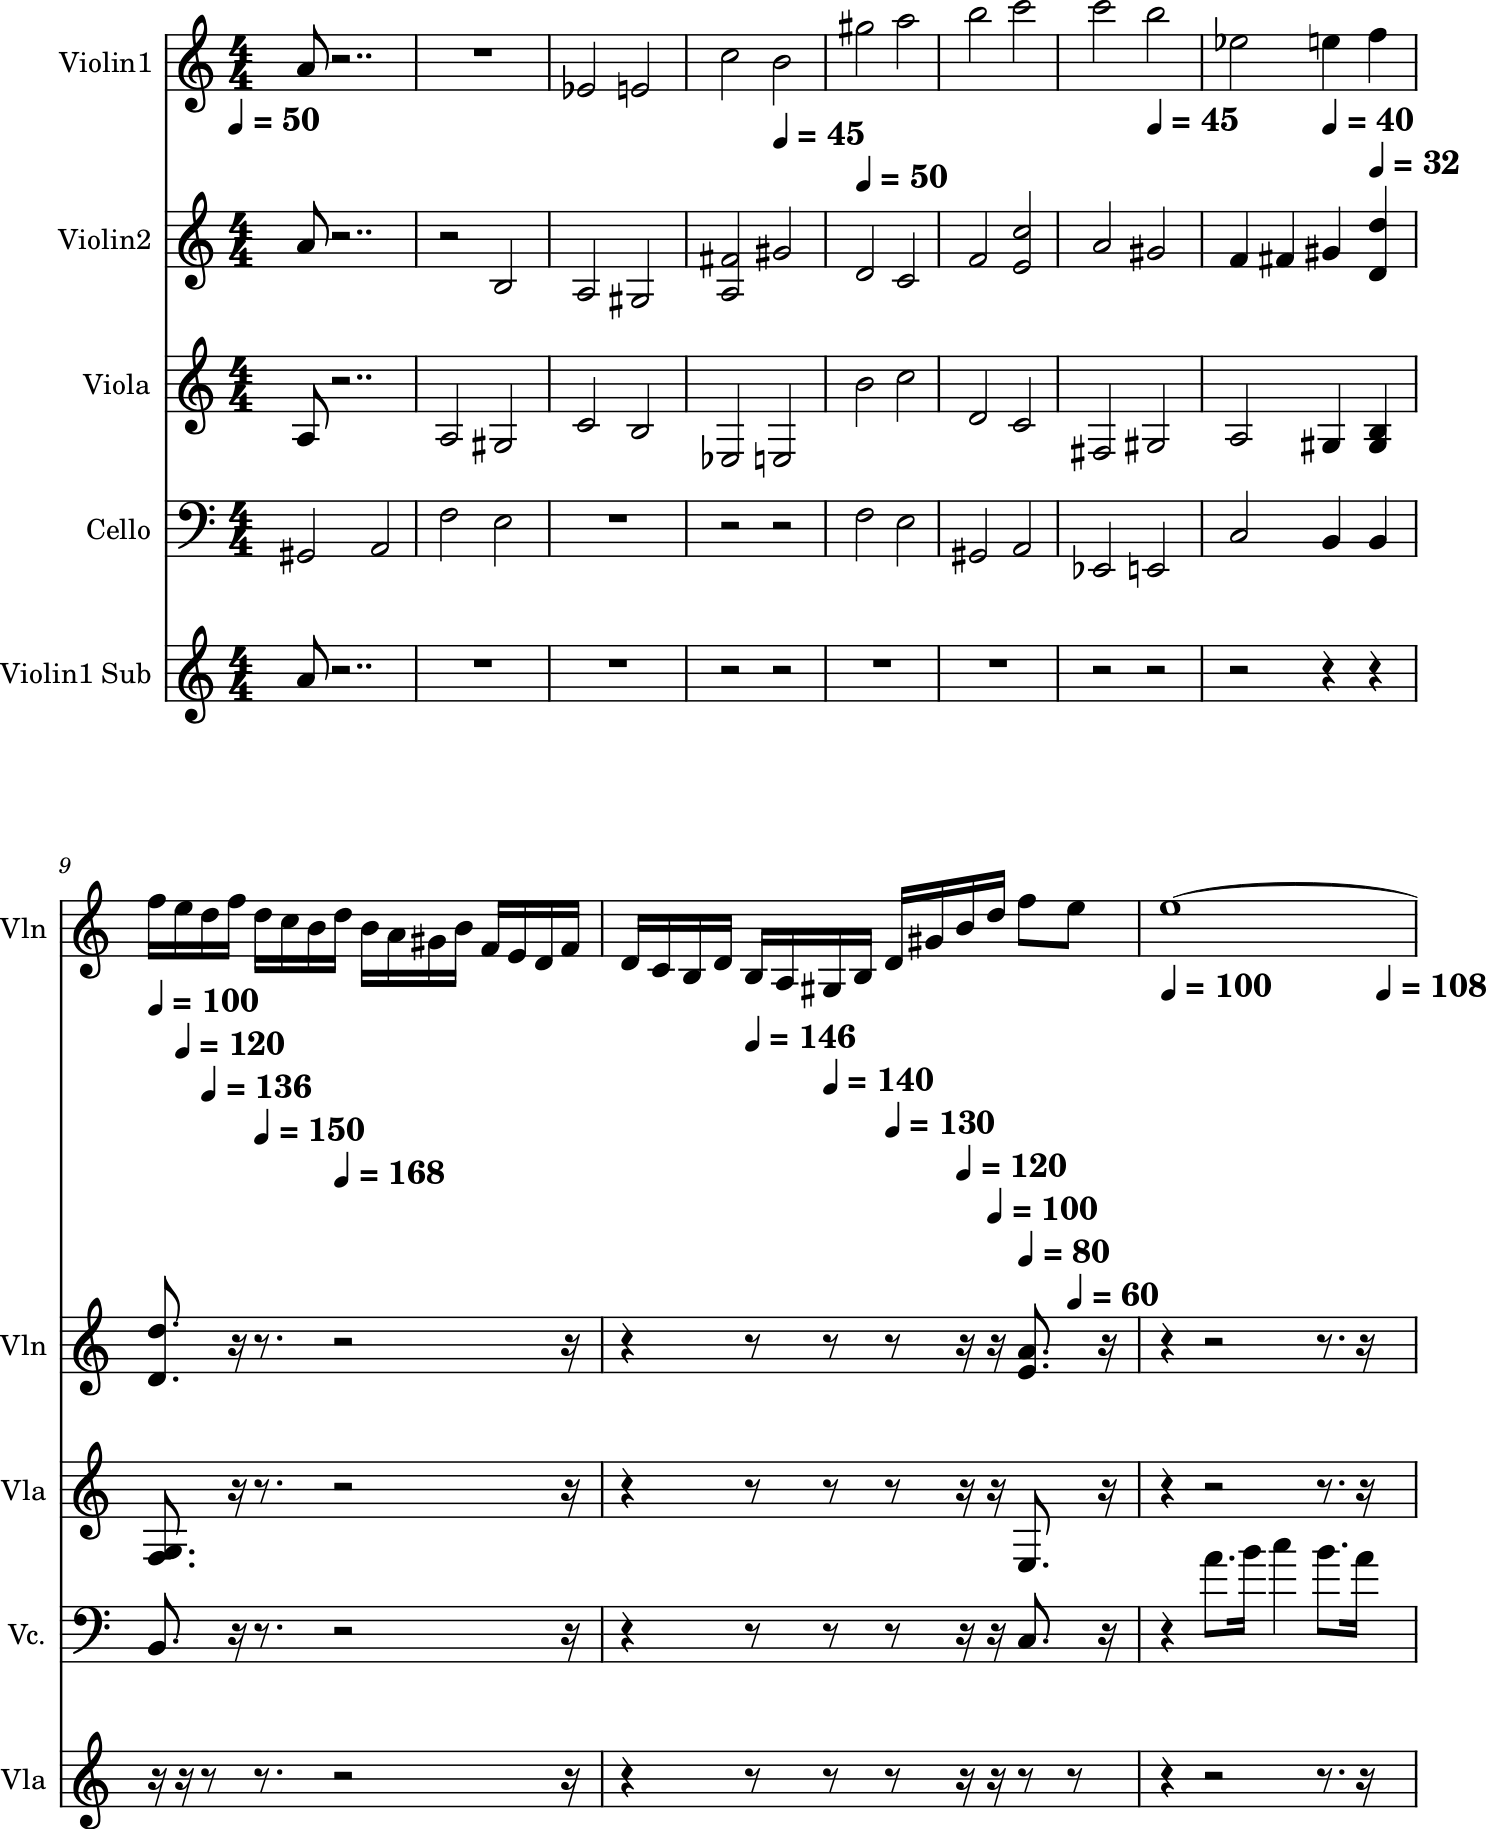

[ 69 129 128 ... 129 129 129]


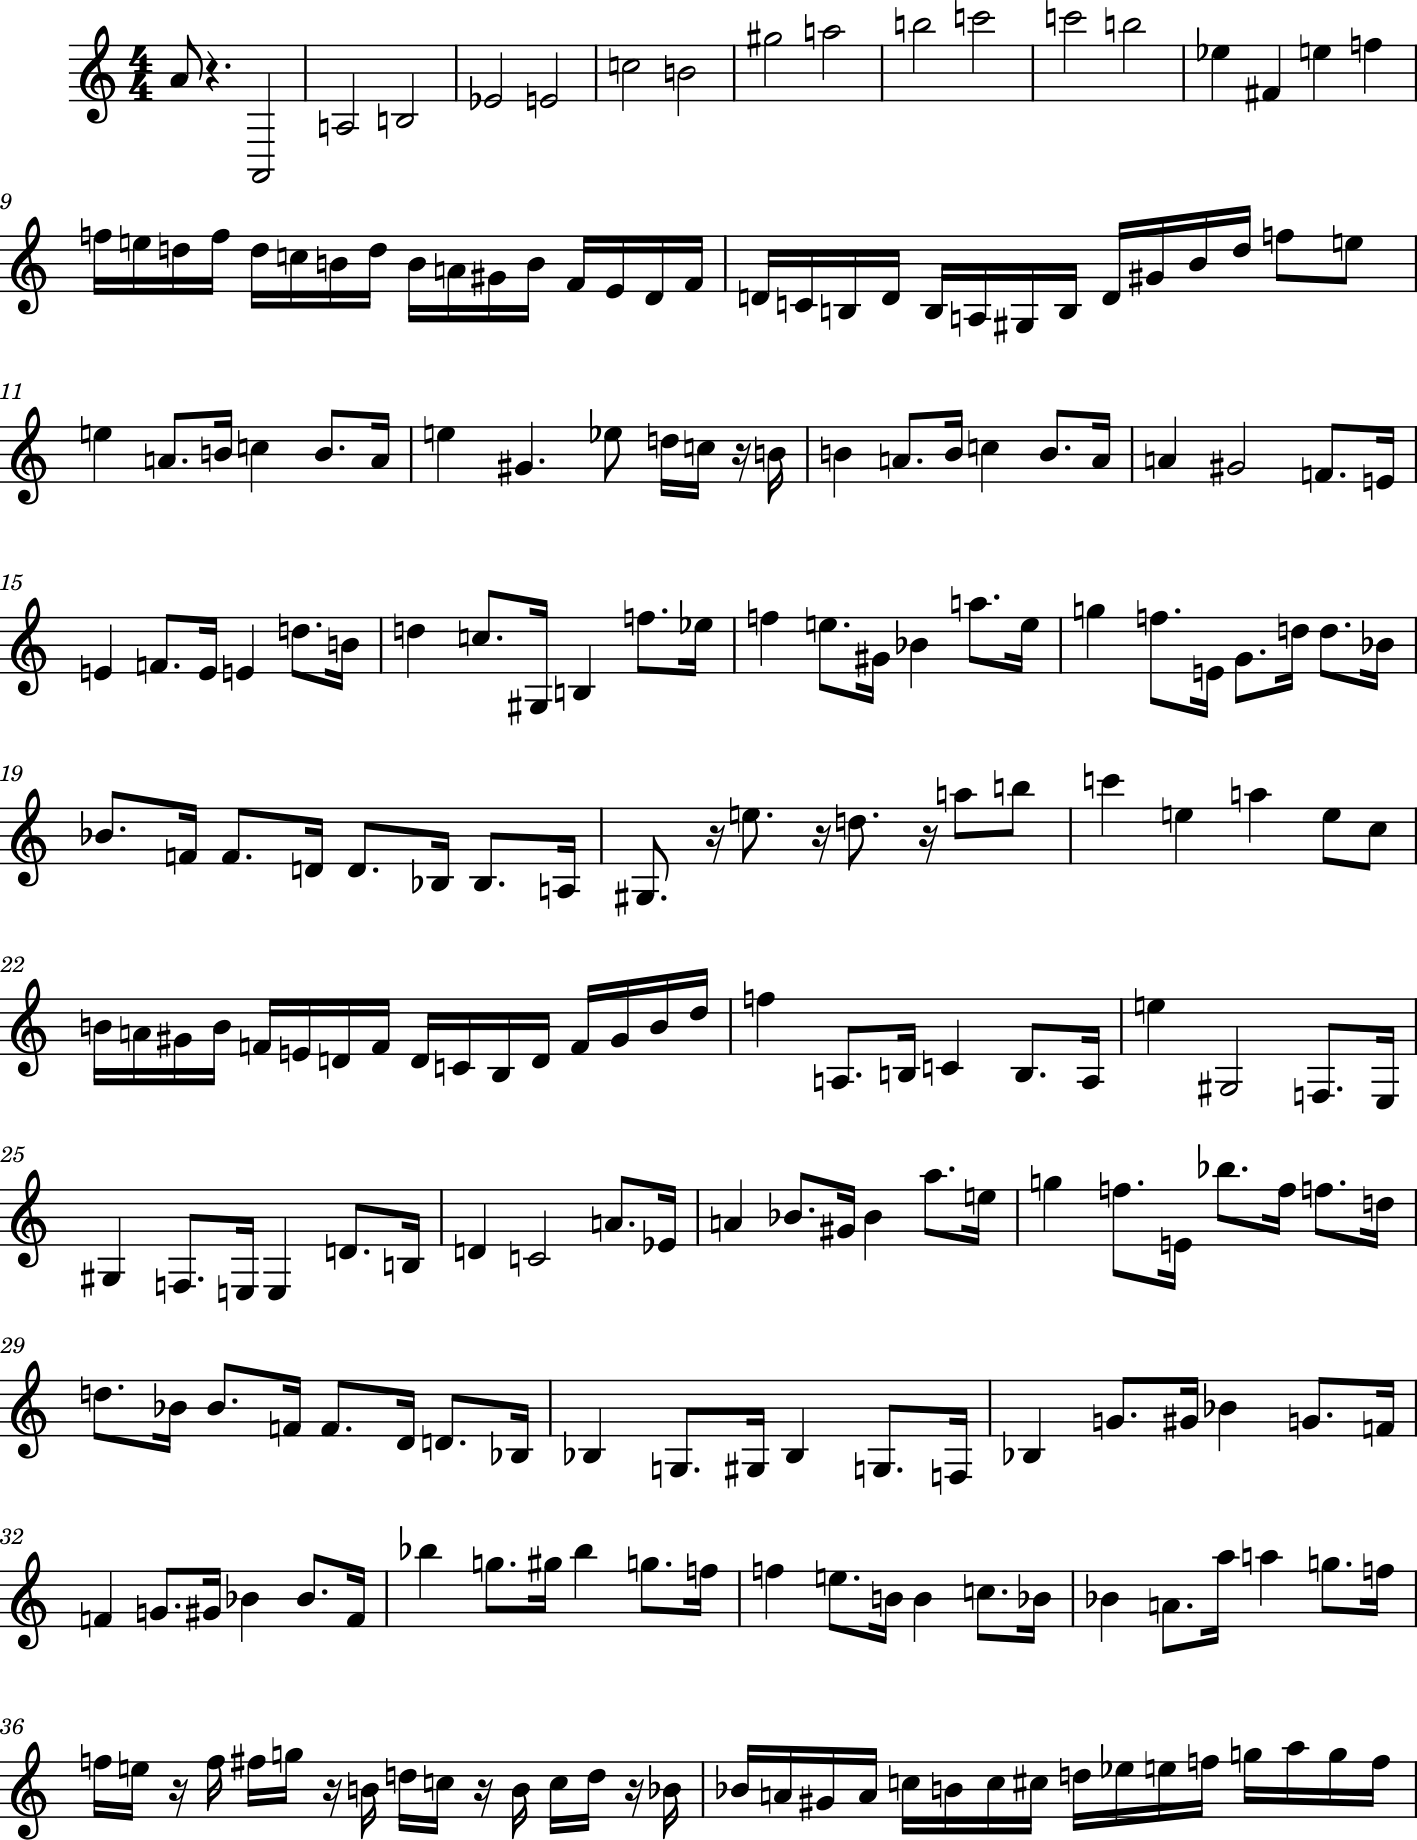

In [47]:
wm_mid = converter.parse(path)
wm_mid.show()
wm_mel_rnn = streamToNoteArray(wm_mid)
print(wm_mel_rnn)
noteArrayToStream(wm_mel_rnn).show()